# True-Color Mosaic

Based on the [](01c-coverage-analysis), this chapter implements a self-contained processing pipeline that downloads and assembles available data with up to a certain configurable threshold of cloud coverage.
The result is a single raster combined image (i.e. a mosaic) in a user-defined Coordinate Reference System.
While the result is individually useful, it is to be seen firstly as a method of verifying that

- The methods discussed in the previous chapters are correct.
- They can be applied for arbitrary areas of interest an are not restricted by the individual tiles prepared by the Copernicus Open Access Hub.

**TODO** Long-Term-Archive? This is the first time where this might be relevant

The next cell contains all configuration parameters.
These parameters are not explicitly verified, and a bad configuration can lead to execution errors.
Code after this cell should not need to be modified in order to successfully generate the desired output.

In [1]:
from datetime import date, timedelta

# the area you want to create a true color image from; will be the first area
# returned from nominatim.openstreetmap.com
region_of_interest = 'Berlin, Germany'

# start and end of the time span from which to select satellite data
start_date = date(2020, 8, 1)
end_date = start_date + timedelta(days=31)

# maximum amount of cloud coverage of a single product in order to be
# considered for the mosaic
max_cloud_cover = 30

# coordinate reference system of the final image; epsg:25833 uses metric units
# with low distortion in Brandenburg and is used by the state department
# of geography (see Sorge and Dreesmann (2004))
target_crs = 'EPSG:25833'

# this determines whether the result is a rectangular image. if this is `True`,
# all pixels outside of the polygon returned from OpenStreetMap Nominatim will
# be transparent (i.e. filled with a `nodata`-value)
discard_exterior_pixels = True

## API Requests

As previously demonstrated, geometries are fetched from OpenStreetMap using the place name given above. The resulting geometry is used to query the Copernicus Open Access Hub for products in the given time frame.

In [2]:
from sentinelsat import SentinelAPI
from sentinel_helpers import search_osm, plot_downloaded_products
import datetime
import os

api = SentinelAPI(os.getenv('SCIHUB_USERNAME'), os.getenv('SCIHUB_PASSWORD'))

footprint = search_osm(region_of_interest)
footprint = footprint[footprint['osm_type'] == 'relation'].iloc[:1]
footprint

,place_id,osm_type,osm_id,display_name,place_rank,category,type,importance,icon,geometry
1,256375666,relation,62422,"Berlin, Deutschland",8,boundary,administrative,0.897539,https://nominatim.openstreetmap.org/ui/mapicon...,"MULTIPOLYGON (((13.08835 52.41963, 13.09021 52..."


The search result is plotted for visual confirmation:

<AxesSubplot:>

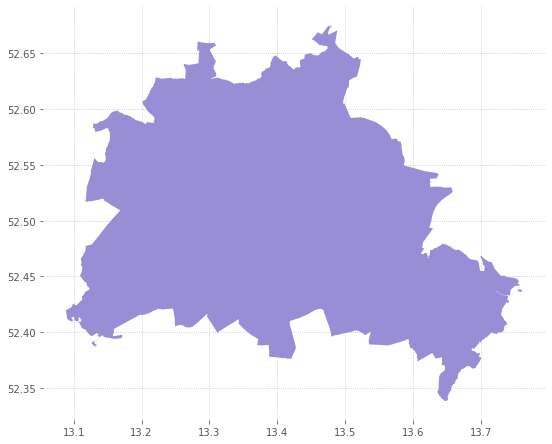

In [3]:
footprint.plot(figsize=(9,9))

The shape from OpenStreetMap is simplified by creating its convex hull, which encompasses all points within the polygon:

In [4]:
convex_hull = footprint['geometry'].unary_union.convex_hull
products = api.query(convex_hull,
                     platformname='Sentinel-2',
                     processinglevel='Level-2A',
                     date=(start_date, end_date),
                     cloudcoverpercentage=(0, max_cloud_cover))

print('Found ' + str(len(products)) + ' results')

Found 33 results


The plot below shows the region of interest in gray in the background and the tiles of the products returned by the search query as purple quadrilaterals.
If multiple results contain data for a given area it appears more opaque and therefore darker.

/opt/conda/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


<AxesSubplot:title={'center':'Area of Interest and Available Products'}>

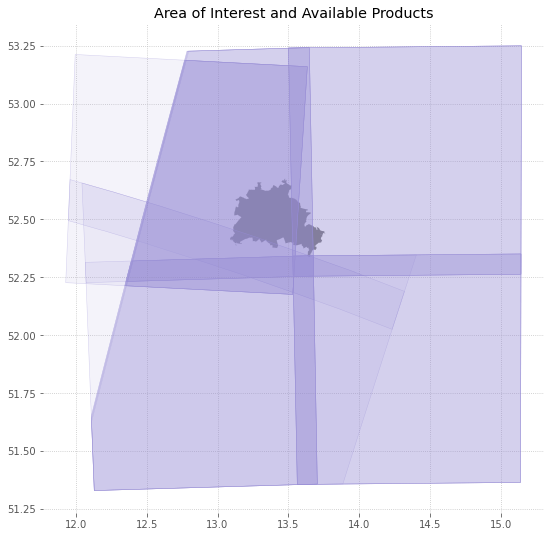

In [5]:
gdf = api.to_geodataframe(products)
plot_downloaded_products(gdf, footprint, figsize=(9,9))

As discussed in [](01c-coverage-analysis) the least cloudy products are more interesting because they contain more ground-level data.
All of the products in the result set are sorted by cloudiness (least cloudy products first) and iterated through, combining them until the entire area of interest is covered.

The products are merged later on so that less cloudy products are favored wherever two products overlap:
They are painted in order and wherever a pixel is already painted, no new pixel is placed.

It is important to note however that cloud coverage of a product is given for the *entire* product.
When, in choosing between two products, the less cloudy product is painted first, a later product, which is left unpainted by the algorithm because it has a higher nominal cloud coverage, might contain fewer clouds on the pixels which are left unpainted.

In [6]:
from tqdm.notebook import tqdm
import geopandas as gpd

gdf = gdf.sort_values(by='cloudcoverpercentage', ascending=True)

geometry = footprint.iloc[0].geometry
for idx, product in tqdm(gdf.iterrows(), total=len(gdf)):
    union = gdf.loc[:idx].unary_union
    if union.contains(geometry):
        break

# drop identical geometries
selection = gdf.loc[:idx].drop_duplicates(subset=['geometry'])

Due to the structure of the loop above, the `tqdm` progress bar will display a number of completed loops that is one less than the number of products included.

Text(0.5, 1.0, 'Selected products')

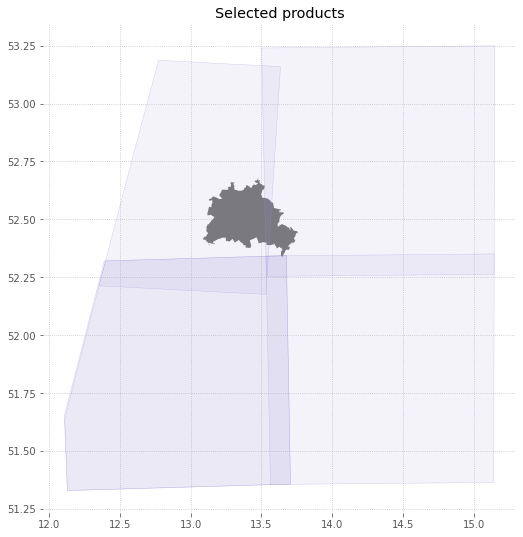

In [7]:
import matplotlib.pyplot as plt

plot_downloaded_products(selection, footprint, figsize=(9,9))
plt.title('Selected products')

These are the same products in a table.
You can use the table to find out information about the exact capture time.

In [8]:
selection

,title,link,link_alternative,link_icon,summary,ondemand,beginposition,endposition,ingestiondate,orbitnumber,...,size,s2datatakeid,producttype,platformidentifier,orbitdirection,platformserialidentifier,processinglevel,identifier,uuid,geometry
3e6fb121-4848-4b9a-ba13-b0a8f17eddd0,S2B_MSIL2A_20200811T100559_N0214_R022_T33UVU_2...,https://scihub.copernicus.eu/apihub/odata/v1/P...,https://scihub.copernicus.eu/apihub/odata/v1/P...,https://scihub.copernicus.eu/apihub/odata/v1/P...,"Date: 2020-08-11T10:05:59.024Z, Instrument: MS...",false,2020-08-11 10:05:59.024,2020-08-11 10:05:59.024,2020-08-11 17:29:01.010,17923,...,1.09 GB,GS2B_20200811T100559_017923_N02.14,S2MSI2A,2017-013A,DESCENDING,Sentinel-2B,Level-2A,S2B_MSIL2A_20200811T100559_N0214_R022_T33UVU_2...,3e6fb121-4848-4b9a-ba13-b0a8f17eddd0,"MULTIPOLYGON (((13.53443 52.25345, 15.14301 52..."
a049c49b-084a-4470-8eff-dc66c9165d86,S2A_MSIL2A_20200816T101031_N0214_R022_T33UVT_2...,https://scihub.copernicus.eu/apihub/odata/v1/P...,https://scihub.copernicus.eu/apihub/odata/v1/P...,https://scihub.copernicus.eu/apihub/odata/v1/P...,"Date: 2020-08-16T10:10:31.024Z, Instrument: MS...",false,2020-08-16 10:10:31.024,2020-08-16 10:10:31.024,2020-08-16 21:03:13.244,26903,...,1.08 GB,GS2A_20200816T101031_026903_N02.14,S2MSI2A,2015-028A,DESCENDING,Sentinel-2A,Level-2A,S2A_MSIL2A_20200816T101031_N0214_R022_T33UVT_2...,a049c49b-084a-4470-8eff-dc66c9165d86,"MULTIPOLYGON (((13.56331 51.35443, 15.14019 51..."
228c87cc-65c3-46dd-9e8e-7e7ec5d713bb,S2A_MSIL2A_20200816T101031_N0214_R022_T33UUT_2...,https://scihub.copernicus.eu/apihub/odata/v1/P...,https://scihub.copernicus.eu/apihub/odata/v1/P...,https://scihub.copernicus.eu/apihub/odata/v1/P...,"Date: 2020-08-16T10:10:31.024Z, Instrument: MS...",false,2020-08-16 10:10:31.024,2020-08-16 10:10:31.024,2020-08-16 20:29:32.653,26903,...,1.03 GB,GS2A_20200816T101031_026903_N02.14,S2MSI2A,2015-028A,DESCENDING,Sentinel-2A,Level-2A,S2A_MSIL2A_20200816T101031_N0214_R022_T33UUT_2...,228c87cc-65c3-46dd-9e8e-7e7ec5d713bb,"MULTIPOLYGON (((12.12921 51.32805, 13.70458 51..."
bb98d140-7bb5-4305-aafe-ebf8add03b94,S2B_MSIL2A_20200811T100559_N0214_R022_T33UUT_2...,https://scihub.copernicus.eu/apihub/odata/v1/P...,https://scihub.copernicus.eu/apihub/odata/v1/P...,https://scihub.copernicus.eu/apihub/odata/v1/P...,"Date: 2020-08-11T10:05:59.024Z, Instrument: MS...",false,2020-08-11 10:05:59.024,2020-08-11 10:05:59.024,2020-08-11 17:26:15.912,17923,...,1.03 GB,GS2B_20200811T100559_017923_N02.14,S2MSI2A,2017-013A,DESCENDING,Sentinel-2B,Level-2A,S2B_MSIL2A_20200811T100559_N0214_R022_T33UUT_2...,bb98d140-7bb5-4305-aafe-ebf8add03b94,"MULTIPOLYGON (((12.12921 51.32805, 13.70458 51..."
06c2fd8a-6efe-4288-af55-e1289f2ea62b,S2B_MSIL2A_20200811T100559_N0214_R022_T32UQD_2...,https://scihub.copernicus.eu/apihub/odata/v1/P...,https://scihub.copernicus.eu/apihub/odata/v1/P...,https://scihub.copernicus.eu/apihub/odata/v1/P...,"Date: 2020-08-11T10:05:59.024Z, Instrument: MS...",false,2020-08-11 10:05:59.024,2020-08-11 10:05:59.024,2020-08-11 17:16:08.434,17923,...,773.18 MB,GS2B_20200811T100559_017923_N02.14,S2MSI2A,2017-013A,DESCENDING,Sentinel-2B,Level-2A,S2B_MSIL2A_20200811T100559_N0214_R022_T32UQD_2...,06c2fd8a-6efe-4288-af55-e1289f2ea62b,"MULTIPOLYGON (((13.53103 52.17548, 13.63418 53..."


We continue by creating the folder structure and initializing the download.

In [9]:
from pathlib import Path
dst_path = Path('resources/true_color_pipeline')
dst_path.mkdir(exist_ok=True, parents=True)

product_ids = selection['uuid'].values

# api._tqdm = tqdm # monkey-patch for nicer progress bars
downloads, _, _ = api.download_all(product_ids, directory_path=dst_path)

Downloading: 100%|██████████| 1.11G/1.11G [00:35<00:00, 5.24MB/s]
MD5 checksumming: 100%|██████████| 1.11G/1.11G [00:03<00:00, 333MB/s]


## Large Area Raster File Generation

This section will perform raster manipulations to achieve three things:

- Combining the separate products so they span the entire area of interest.
- Reprojecting the combined products to match the coordinate reference system given by `target_crs`.
- Spatially subsetting the products (i.e. crop them) so that unneeded pixels are discarded form the result. This results, depending of the  value of `discard_exterior_pixels`, either in a polygonal or a strictly rectangular output file.

### Reprojection

As a first step bands 2, 3 and 4 from all selected products are individually reprojected and saved in a temporary file.

In [10]:
import matplotlib.pyplot as plt
import rasterio as r
from rasterio import plot as rplot
from rasterio.warp import calculate_default_transform, reproject, Resampling
from sentinel_helpers import RasterReaderList, scihub_band_paths

def reproject_band(band_path):
    '''
    Reprojects a single band to the `target_crs` defined above. Returns the
    path of the reprojected image.
    '''
    global target_crs
    
    with r.open(band_path) as src:# create a temporary file to write the output to
        tmp_path = Path('/tmp/reprojected/') / target_crs / Path(src.name.replace('zip+file://', '').replace('.zip!', ''))
        tmp_path.parent.mkdir(exist_ok=True, parents=True)
        
        # this code is written as shown on https://rasterio.readthedocs.io/en/latest/topics/reproject.html
        transform, width, height = calculate_default_transform(
            src.crs, target_crs, src.width, src.height, *src.bounds)
        
        kwargs = src.meta.copy()
        kwargs.update({
            'crs': target_crs,
            'transform': transform,
            'width': width,
            'height': height
        })
        
        with r.open(tmp_path, 'w', **kwargs) as dst:
            reproject(
                source=r.band(src, 1),
                destination=r.band(dst, 1),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=target_crs,
                resampling=Resampling.nearest)
        
        return tmp_path

The output of each reprojection is independend - the only dependency is a band path. Implementing these operations as independent functions allows for parallel execution using the `multiprocessing` module from the Python standard library.

Because Python does not support multithreading primitives, individual Python processes have to be started to distribute work across multiple cores. This is a rather expensive operation that can make some operations even slower, albeit performed in parallel. The overhead of starting individual processes can outweigh the benefit of parallelization.

Benchmarks are left out in this case because each reprojection operation runs multiple tens of seconds, which is far longer than what it takes to start a single process.parallel

In [14]:
%%time
from multiprocessing import Pool

downloaded_paths = [d['path'] for d in downloads.values()]
bands = ['B02', 'B03', 'B04']
bands = [band for product in downloaded_paths for band in scihub_band_paths(product, bands, '10m')]

with Pool() as pool:
    # we use the multiprocessing pool to reproject the rasters in parallel
    reprojected_rasters = [raster for raster in tqdm(pool.imap_unordered(reproject_band, bands), desc='Reprojecting bands', total=len(bands))]


CPU times: user 150 ms, sys: 182 ms, total: 332 ms
Wall time: 5min 18s


### Band Merge

Reprojected raster files are merged per band using the `merge` function in the `rasterio.merge` module.
In contrast to the reprojection just performed, this task cannot trivially be parallelized because the result of each step depends on the output of the previous step.
The result of this process is one file per band covering the entire area of interest.

In [15]:
%%time

from rasterio.merge import merge
from collections import defaultdict

# we build an index that allows us to access subsets of the raster path list
# above by their band number because we need to merge them separately
grouped_by_band = defaultdict(list)
merged = {}

for raster in reprojected_rasters:
    file_name = raster.name
    band = file_name.split('_')[-2]
    grouped_by_band[band].append(raster)
    
# this index is now used to merge the different products, in the end forming a
# product that contains data for one band an covers the entire area of interest
for band, paths in tqdm(grouped_by_band.items(), desc='Merging bands to cover the entire area of interest'):
    with RasterReaderList(paths) as raster_readers:
        # note that mosaic_transform (the affine matrix describing the
        # coordinate transformation in the merged raster) will get overwritten
        # in each loop pass. that's ok because all mosaic_transforms
        # are identical
        mosaic, mosaic_transform = merge(raster_readers)
        merged[band] = mosaic


CPU times: user 5min 3s, sys: 30.3 s, total: 5min 33s
Wall time: 2min 4s


## Output

As a final step the merged products are cropped and all separate bands are combined into a single raster file.
The output path is given and the result is plotted at the end of the notebook.

Wrote resulting raster file to resources/true_color_mosaic/tci-berlin-germany.tif
CPU times: user 17.5 s, sys: 27.8 s, total: 45.3 s
Wall time: 45.2 s


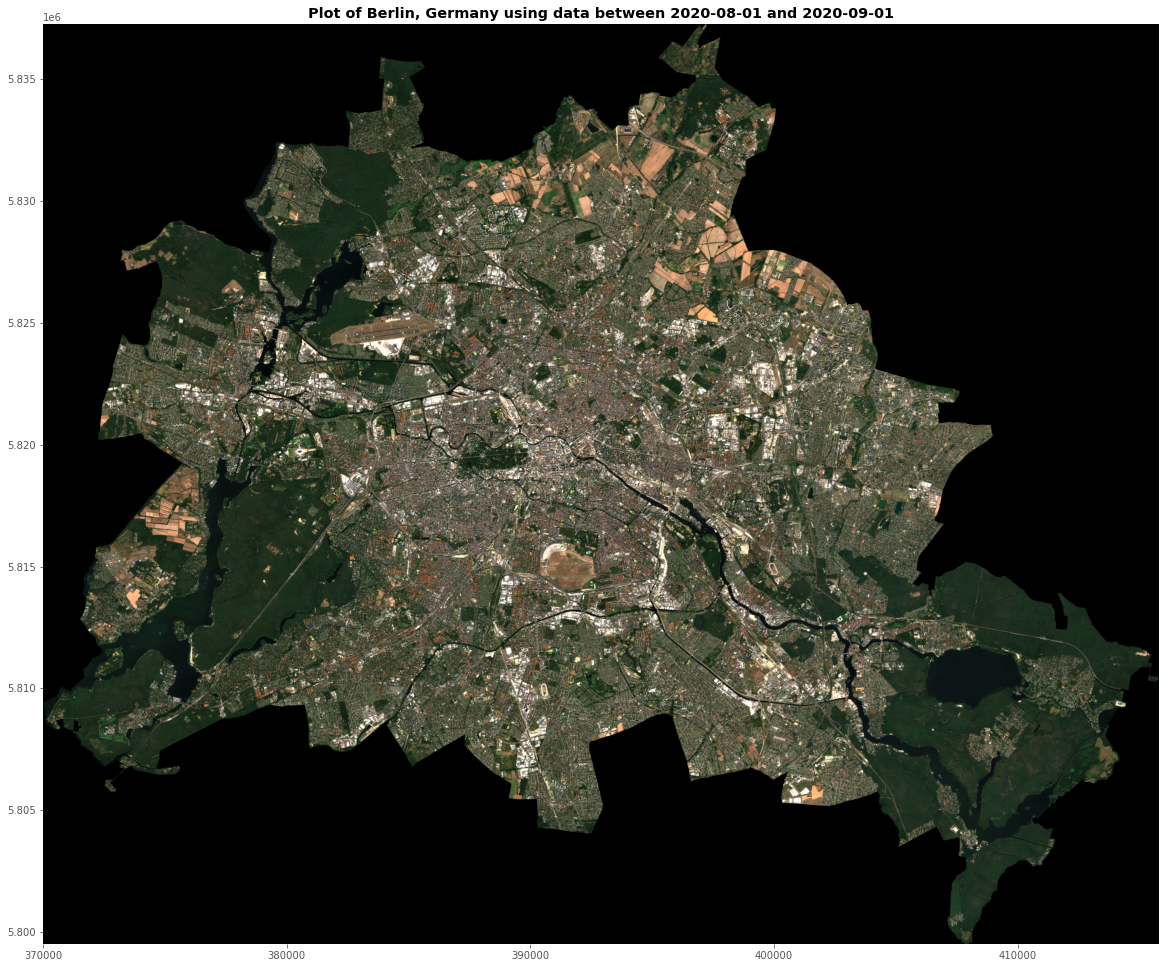

In [19]:
%%time

import numpy as np
import re
from rasterio.io import MemoryFile
import rasterio.mask as rmask
from shapely.geometry import box

_, height, width = merged['B03'].shape

# these arguments will be passed to rasterio when writing the resulting file
kwargs = {
    'count': 3,
    'crs': target_crs,
    'width': width,
    'height': height,
    'transform': mosaic_transform,
    'driver': 'GTiff',
    'dtype': np.uint8
}

# generate a nice output filename based on the region of interest given above
out_name = re.sub(r'[^\w]', '-', region_of_interest).lower()
out_name = 'tci-' + re.sub(r'-+', '-', out_name) + '.tif'

def normalize_rgb(v):
    return (np.clip(v, 0, max_val) / max_val * 255).astype(np.uint8)

with MemoryFile() as memfile, memfile.open(**kwargs) as tmp:
    # combine the separate bands and convert them to integers in the range [0, 255]
    max_val = 2000
    tmp.write(normalize_rgb(merged['B04'][0]), 1)
    tmp.write(normalize_rgb(merged['B03'][0]), 2)
    tmp.write(normalize_rgb(merged['B02'][0]), 3)
    
    # generate the mask based on the region of interest
    mask_shape = footprint.to_crs(target_crs).iloc[0].geometry
    if not discard_exterior_pixels:
        mask_shape = box(*mask_shape.bounds)
    
    masked, masked_transform = rmask.mask(tmp, shapes=[mask_shape], crop=True)
    _, height, width = masked.shape
    
    # show the result
    fig, ax = plt.subplots(figsize=(20,20))
    ax.grid(False)
    rplot.show(masked,
               ax=ax,
               transform=masked_transform,
               title=f'Plot of {region_of_interest} using data between {start_date.strftime("%Y-%m-%d")} and {end_date.strftime("%Y-%m-%d")}')
    
    # adjust the output dimensions and save the output
    kwargs.update({
        'width': width,
        'height': height,
        'transform': masked_transform
    })
    
    output_path = Path('resources/true_color_mosaic')
    output_path.mkdir(exist_ok=True, parents=True)
    with r.open(output_path / out_name, 'w', **kwargs) as dst:
        dst.write(masked)
        print(f'Wrote resulting raster file to {output_path / out_name}')